# Task 2: Clustering

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Customer Profile model

In [296]:
customer_profile = pd.read_csv('../dataset/customer_profile_model.csv', sep='\t', index_col=0)
customer_profile

,I,Iu,Imax,E,Monetary,Recency,T,Frequency
CustomerID,,,,,,,,
12747.0,6.674561,3.367296,4.941642,1.451864,5.467406,5.762051,5.831882,2.079442
12748.0,9.485925,7.273786,7.108244,1.888435,5.229524,5.814131,5.828946,4.553877
12749.0,7.110696,4.787492,6.439350,1.532598,6.259295,5.746203,5.817111,1.098612
12820.0,6.513230,3.988984,5.497168,1.393521,5.525665,5.641907,5.789960,1.098612
12822.0,6.122493,3.610918,5.913503,1.413603,5.049728,2.833213,4.477337,0.000000
...,...,...,...,...,...,...,...,...
18272.0,7.367709,4.477337,5.863631,1.550851,6.203733,5.407172,5.420535,1.609438
18273.0,3.688879,0.000000,2.995732,-2.302585,3.931826,4.672829,5.552960,0.000000
18282.0,3.931826,2.079442,3.258097,1.047319,4.107425,4.442651,5.707110,0.000000


In [283]:
customer_profile = customer_profile.to_numpy()

## Standardization \& Dimensionality Reduction

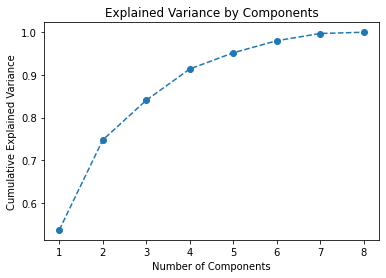

In [284]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
std_customer_profile = scaler.fit_transform(customer_profile)

pca = PCA()
pca.fit(std_customer_profile)

plt.plot(range(1, customer_profile.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

The graph shows the amount of variance captured depending on the number of components we include. A rule of thumb is to preserve around 80% of the variance. So, in this instance, we decide to keep 2 components.

In [285]:
pca = PCA(n_components=2)
pca_customer_profile = pca.fit_transform(std_customer_profile)

In [ ]:
from sklearn.metrics import silhouette_score

## K-means

In [286]:
from sklearn.cluster import KMeans

In [287]:
score = []
for k in range(2, 10):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    clusters = kmeans.fit_predict(pca_customer_profile)
    score.append(kmeans.inertia_)
    print("For k =", k, "the silhouette score is:", silhouette_score(pca_customer_profile, clusters))

For k = 2 the silhouette score is: 0.40845663431509427
For k = 3 the silhouette score is: 0.34866176031100815
For k = 4 the silhouette score is: 0.3711949399779862
For k = 5 the silhouette score is: 0.3313184845296722
For k = 6 the silhouette score is: 0.339490685094876
For k = 7 the silhouette score is: 0.3401644632642818
For k = 8 the silhouette score is: 0.331007961620649
For k = 9 the silhouette score is: 0.3283905232125472


The best silhouette score obtained is when the number of clusters is 2.

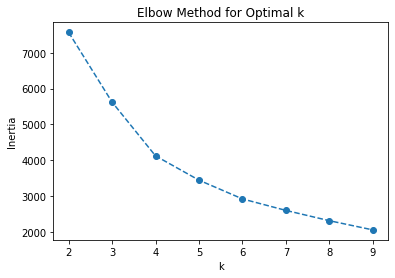

In [288]:
plt.plot(range(2, 10), score, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.ylabel('Inertia')
plt.xlabel('k');

In [289]:
kmeans = KMeans(init='k-means++', n_clusters=2)
clusters_customers = kmeans.fit_predict(pca_customer_profile)

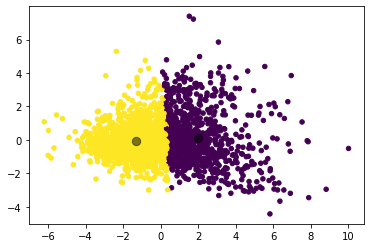

In [290]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20)
# select cluster centers
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

What's the number of customers in each cluster?

In [291]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,1,0
CustomersNb,1375,902


For comparison, if we run only the k-means algorithm without the PCA step, the result would be the following:

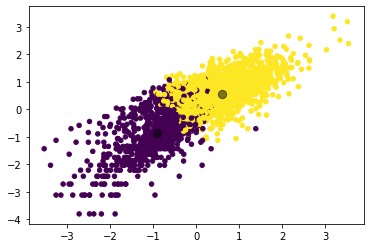

In [292]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20)
# select cluster centers
centroids = pca.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

## DBSCAN

In [229]:
from sklearn.cluster import DBSCAN

In [230]:
for eps in (0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5):
    dbscan = DBSCAN(eps=eps, min_samples=10)
    clusters = dbscan.fit_predict(pca_customer_profile)
    print("For eps =", eps, "the silhouette score is:", silhouette_score(pca_customer_profile, clusters))

For eps = 0.1 the silhouette score is: -0.49181009078425025
For eps = 0.15 the silhouette score is: -0.4261456444763971
For eps = 0.2 the silhouette score is: -0.27122287387517613
For eps = 0.25 the silhouette score is: -0.061241375957141755
For eps = 0.3 the silhouette score is: 0.2459351431418358
For eps = 0.35 the silhouette score is: 0.4328829080621841
For eps = 0.4 the silhouette score is: 0.4507804235377279
For eps = 0.45 the silhouette score is: 0.3523764513596492
For eps = 0.5 the silhouette score is: 0.39228585871922855


The best silhouette score obtained is when the eps is 0.4.

In [231]:
dbscan = DBSCAN(eps=0.4, min_samples=10)
clusters_customers = dbscan.fit_predict(pca_customer_profile)

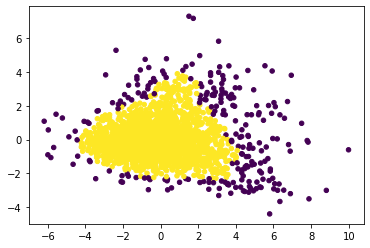

In [232]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [233]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,0,-1
CustomersNb,2045,236


For comparison, if we run only the DBSCAN algorithm without the PCA step, the result would be the following:

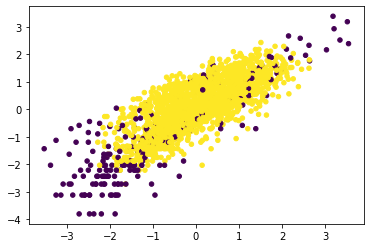

In [234]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20);

## Agglomerative Clustering

In [235]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion:

- *Ward* minimizes the euclidean distance of the clusters being merged (is the hierarchical analogue of K-means, so it can be used to initialize it)
    - strength: less susceptible to noise and outliers
    - limitations: biased towards globular clusters
- *single* or *maximum linkage* uses the minimum of the distances between all observations of the two sets
    - strength: can handle non-elliptical shapes
    - limitations: sensitive to noise and outliers
- *complete* or *maximum linkage* uses the maximum distances between all observations of the two sets
    - strength: less susceptible to noise and outliers
    - limitations: tends to break large clusters, biased towards globular clusters
- *average* linkage is a compromise between *single* and *complete* linkage by using the average of the distances of each observation of the two sets
    - strength: less susceptible to noise and outliers
    - limitations: biased towards globular clusters

### Ward Linkage

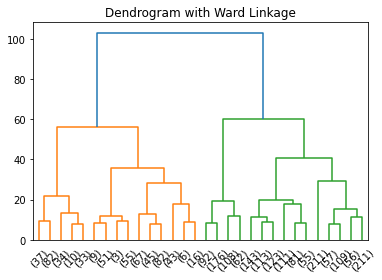

In [268]:
plt.title('Dendrogram with Ward Linkage')
ward_dendo = shc.dendrogram((shc.linkage(pca_customer_profile, method ='ward')), truncate_mode='lastp')

The above image shows that the optimal number of clusters should be 2 for the given data.

In [254]:
for k in range(2, 10):
    agglomerative = AgglomerativeClustering(n_clusters=k, linkage='ward')
    clusters = agglomerative.fit_predict(pca_customer_profile)
    print("For k =", k, "the silhouette score is:", silhouette_score(pca_customer_profile, clusters))

For k = 2 the silhouette score is: 0.43440489907301244
For k = 3 the silhouette score is: 0.29214185283927346
For k = 4 the silhouette score is: 0.3078640276703376
For k = 5 the silhouette score is: 0.2886983691066405
For k = 6 the silhouette score is: 0.29598333488897804
For k = 7 the silhouette score is: 0.26941701103924415
For k = 8 the silhouette score is: 0.2773549831893458
For k = 9 the silhouette score is: 0.2768942672427241


The best silhouette score obtained is when the number of clusters is 2.

In [255]:
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters_customers = agglomerative.fit_predict(pca_customer_profile)

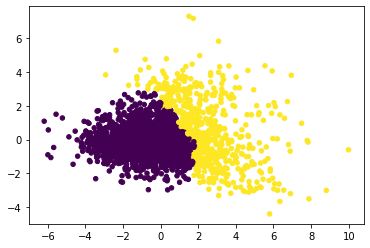

In [256]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [257]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,0,1
CustomersNb,1708,573


For comparison, if we run only the agglomerative clustering algorithm with the Ward linkage without the PCA step, the result would be the following:

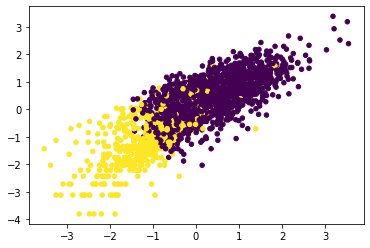

In [258]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20);

### Single Linkage

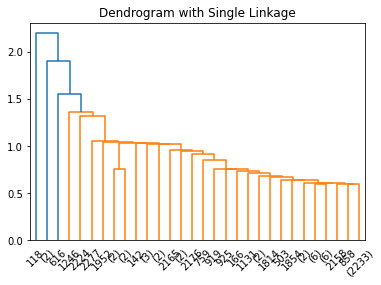

In [267]:
plt.title('Dendrogram with Single Linkage') 
min_dendo = shc.dendrogram((shc.linkage(pca_customer_profile, method ='single')), truncate_mode='lastp')

The above image shows that the optimal number of clusters should be 2 for the given data.

In [260]:
for k in range(2, 10):
    agglomerative = AgglomerativeClustering(n_clusters=k, linkage='single')
    clusters = agglomerative.fit_predict(pca_customer_profile)
    print("For k =", k, "the silhouette score is:", silhouette_score(pca_customer_profile, clusters))

For k = 2 the silhouette score is: 0.6830090478531597
For k = 3 the silhouette score is: 0.5780552235810542
For k = 4 the silhouette score is: 0.4716611125397759
For k = 5 the silhouette score is: 0.3742849552044646
For k = 6 the silhouette score is: 0.35826592996605555
For k = 7 the silhouette score is: 0.3499588784341579
For k = 8 the silhouette score is: 0.34677672037539325
For k = 9 the silhouette score is: 0.32118783683953184


The best silhouette score obtained is when the number of clusters is 2.

In [261]:
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='single')
clusters_customers = agglomerative.fit_predict(pca_customer_profile)

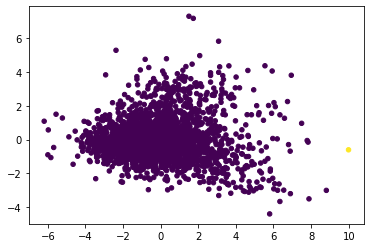

In [262]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [263]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,0,1
CustomersNb,2280,1


For comparison, if we run only the agglomerative clustering algorithm with the single linkage without the PCA step, the result would be the following:

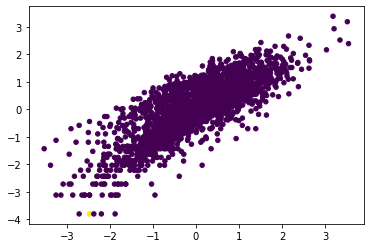

In [264]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20);

### Complete Linkage

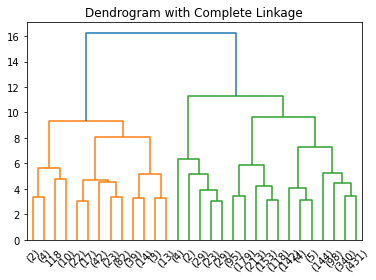

In [269]:
plt.title('Dendrogram with Complete Linkage') 
max_dendo = shc.dendrogram((shc.linkage(pca_customer_profile, method ='complete')), truncate_mode='lastp')

The above image shows that the optimal number of clusters should be 2 for the given data.

In [270]:
for k in range(2, 10):
    agglomerative = AgglomerativeClustering(n_clusters=k, linkage='complete')
    clusters = agglomerative.fit_predict(pca_customer_profile)
    print("For k =", k, "the silhouette score is:", silhouette_score(pca_customer_profile, clusters))

For k = 2 the silhouette score is: 0.4663500355336099
For k = 3 the silhouette score is: 0.3613961051236705
For k = 4 the silhouette score is: 0.23537927551918253
For k = 5 the silhouette score is: 0.22407744769406132
For k = 6 the silhouette score is: 0.24113698968024816
For k = 7 the silhouette score is: 0.17407186787906767
For k = 8 the silhouette score is: 0.17137346540763115
For k = 9 the silhouette score is: 0.20137174990240056


The best silhouette score obtained is when the number of clusters is 2.

In [271]:
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='complete')
clusters_customers = agglomerative.fit_predict(pca_customer_profile)

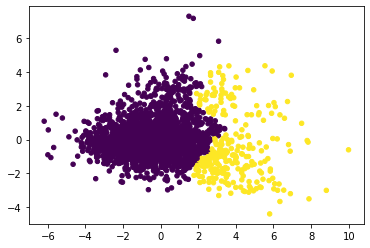

In [272]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [273]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,0,1
CustomersNb,2009,272


For comparison, if we run only the agglomerative clustering algorithm with the complete linkage without the PCA step, the result would be the following:

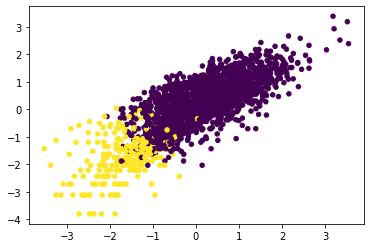

In [274]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20);

### Average Linkage

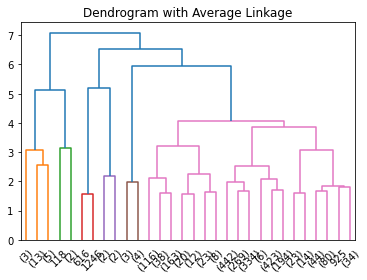

In [275]:
plt.title('Dendrogram with Average Linkage') 
avg_dendo = shc.dendrogram((shc.linkage(pca_customer_profile, method ='average')), truncate_mode='lastp')

The above image shows that the optimal number of clusters should be 2 for the given data.

In [276]:
for k in range(2, 10):
    agglomerative = AgglomerativeClustering(n_clusters=k, linkage='average')
    clusters = agglomerative.fit_predict(pca_customer_profile)
    print("For k =", k, "the silhouette score is:", silhouette_score(pca_customer_profile, clusters))

For k = 2 the silhouette score is: 0.5592296124766138
For k = 3 the silhouette score is: 0.49282809353708745
For k = 4 the silhouette score is: 0.37572772740927773
For k = 5 the silhouette score is: 0.34910887862296036
For k = 6 the silhouette score is: 0.3373378508592329
For k = 7 the silhouette score is: 0.2996643905135835
For k = 8 the silhouette score is: 0.3362904981572354
For k = 9 the silhouette score is: 0.30547544453798775


The best silhouette score obtained is when the number of clusters is 2.

In [277]:
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='average')
clusters_customers = agglomerative.fit_predict(pca_customer_profile)

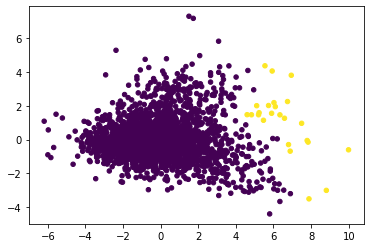

In [278]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [279]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,0,1
CustomersNb,2257,24


For comparison, if we run only the agglomerative clustering algorithm with the average linkage without the PCA step, the result would be the following:

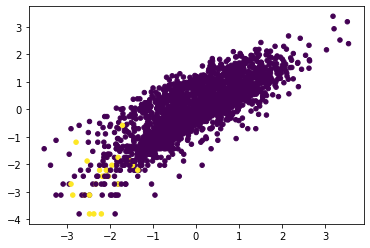

In [280]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20);